# Precision Medicine Analysis
---

## Objective

- Build out a machine learning model from real genetic data (Breast Cancer Dataset 29 SNPs)
- Apply to any genetic dataset to find change in risk (phenotype) of editing each SNP variant (genotype) of subject

## Steps
1. See `TPOT_Breast_Cancer_Data.py` for `tpot` model fitted to test/validate dataset 
2. Visualization tests with probability machines model:
    1. Overlay predicted distribution of healthy subjects to case subjects in test/validate dataset
    2. Overlay predicted distribution of healthy subjects to case subjects in precision medicine dataset
4. Systematically change genotype of SNP variants, effect on change in risk measured
5. Minimization applied to change in risk function determines optimal SNP edit


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the class is labeled 'target' in the data file
test_val_data = pd.read_csv('~/Documents/MooreLab/test_validate_data.csv', sep=',', dtype=np.float64)
features = test_val_data.drop('phenotype', axis=1).values

tv_training_features, tv_testing_features, tv_training_target, tv_testing_target = \
            train_test_split(features, test_val_data['phenotype'].values, random_state=42)

# Average CV score on the training set was:0.5596198830409357
exported_pipeline = ExtraTreesClassifier(bootstrap=False, random_state = 42, criterion="entropy", max_features=0.1, min_samples_leaf=18, min_samples_split=20, n_estimators=100)
exported_pipeline.fit(tv_training_features, tv_training_target)


## From here downwards, we don't really do anything w TRAINING data, only visualize on test_target & test_features
print(exported_pipeline.score(tv_testing_features, tv_testing_target)) # Score of ML pipeline on test data (features & target)

results = exported_pipeline.predict(tv_testing_features)               # Predicted 0 or 1 for each participant

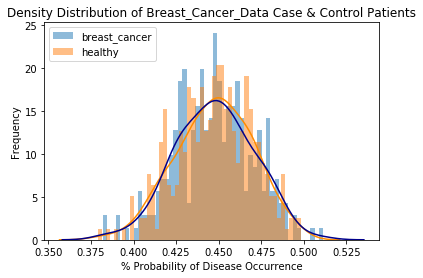

In [2]:
tv_testing_features_cancer = tv_testing_features[tv_testing_target == 1,:]             # All the rows with phenotype 1
tv_testing_features_healthy = tv_testing_features[tv_testing_target != 1,:]           # All the rows without phenotype 1


tv_prob_test_healthy = exported_pipeline.predict_proba(tv_testing_features_healthy)    # Predict_proba of these features
tv_prob_test_phenotype_healthy = tv_prob_test_healthy[:,1]                             # Extract correct probability of phenotype =1

tv_prob_test_cancer = exported_pipeline.predict_proba(tv_testing_features_cancer)
tv_prob_test_phenotype_cancer = tv_prob_test_cancer[:,1]

plt.hist(tv_prob_test_phenotype_cancer, bins = 50, alpha=0.5, label='breast_cancer', density=True)
plt.hist(tv_prob_test_phenotype_healthy, bins = 50, alpha=0.5, label='healthy', density=True)
sns.distplot(tv_prob_test_phenotype_healthy, hist=False, kde=True, 
             bins=50, color = 'darkorange')
sns.distplot(tv_prob_test_phenotype_cancer, hist=False, kde=True, 
             bins=50, color = 'darkblue')
plt.legend(loc='upper left')
plt.xlabel('% Probability of Disease Occurrence')
plt.ylabel('Frequency')
plt.title('Density Distribution of Breast_Cancer_Data Case & Control Patients')
plt.show()

[Subject id typed, compute risk...]
plt.verticalline(xint = ...)
plt.show()
[SNP modified]
plt.verticaldash()
plt.show()


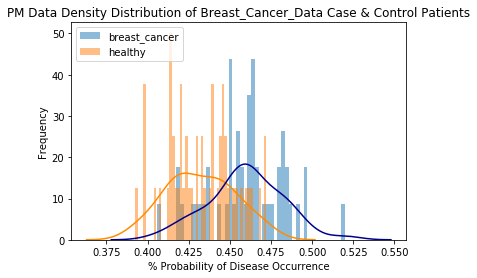

In [3]:
# Load precision medicine dataset; visualize density distribution of healthy & cancer cases

premed_100data = pd.read_csv('~/Documents/MooreLab/premed.csv', sep=',', dtype=np.float64)
n_subs = premed_100data.shape[0]
n_snps = premed_100data.shape[1]-1

healthy_50 = premed_100data.loc[premed_100data.phenotype == 0, :]
features_pm_healthy_50 = healthy_50.drop('phenotype', axis=1).values 

cancer_50 = premed_100data.loc[premed_100data.phenotype != 0, :]
features_pm_cancer_50 = cancer_50.drop('phenotype', axis=1).values         

pm_prob_test_healthy_50 = exported_pipeline.predict_proba(features_pm_healthy_50)   
pm_prob_test_phenotype_healthy_50 = pm_prob_test_healthy_50[:,1]                            
pm_prob_test_cancer_50 = exported_pipeline.predict_proba(features_pm_cancer_50)
pm_prob_test_phenotype_cancer_50 = pm_prob_test_cancer_50[:,1]

plt.hist(pm_prob_test_phenotype_cancer_50, bins = 50, alpha=0.5, label='breast_cancer', density=True)
plt.hist(pm_prob_test_phenotype_healthy_50, bins = 50, alpha=0.5, label='healthy', density=True)
sns.distplot(pm_prob_test_phenotype_healthy_50, hist=False, kde=True, 
             bins=50, color = 'darkorange')
sns.distplot(pm_prob_test_phenotype_cancer_50, hist=False, kde=True, 
             bins=50, color = 'darkblue')
plt.legend(loc='upper left')
plt.xlabel('% Probability of Disease Occurrence')
plt.ylabel('Frequency')
plt.title('PM Data Density Distribution of Breast_Cancer_Data Case & Control Patients')
plt.show()

In [1]:
# Changing each SNP and seeing resulting predict_proba difference in an array of ONE individual

SNP_names = list(premed_100data.columns.values)
SNP_names.pop(n_snps)
participant_table = []

for row in range(0, n_subs):
    all_info = []
    val = premed_100data.loc[row,:].drop('phenotype').values
    trlarr = val.reshape(1, -1)
    original_prob = exported_pipeline.predict_proba(trlarr)[0,1]

    mylistup = []
    mylistdown = []
    
    for snp in range(0, val.size):
        val[snp] = (val[snp] + 1) % 3
        probup = exported_pipeline.predict_proba(val.reshape(1, -1))[0,1]
        mylistup.append(probup)
        
        val[snp] = (val[snp] - 2) % 3 # -2+1=-1
        probdown = exported_pipeline.predict_proba(val.reshape(1, -1))[0,1]
        mylistdown.append(probdown)
        
        val[snp] = (val[snp] + 1) % 3 # change back
        
    upbumplist = mylistup - original_prob
    downbumplist = mylistdown - original_prob
    uplist = upbumplist.tolist()
    downlist = downbumplist.tolist()
    
    completelist = uplist + downlist + [0] # 0 for no change
    min_index = np.argmin(completelist)
    min_value = min(completelist)
    best_prob = min_value + original_prob
    all_info.append(row + 1) # participant idx
    
    all_info.extend((original_prob, best_prob, original_prob-best_prob))
    if (min_index == (n_snps*2+1)): # no change is best
        all_info.extend(("N/A", "N/A", "N/A"))
    else:
        SNP_idx = min_index % n_snps
        all_info.extend((SNP_names[SNP_idx], int(val[SNP_idx]),
                        int((val[SNP_idx] - 1 + 2*float(min_index <= n_snps)) % 3)))
    
    participant_table.append(all_info)
    


NameError: name 'premed_100data' is not defined

In [5]:
final_df = pd.DataFrame(participant_table, columns = list([
    'Participant Idx', 'Original Prob.', 'Best Possible Prob.', 'Risk Decrease', 'SNP Name', 'Ori. SNP Value', 'New SNP Value']))

In [6]:
final_df.sort_values(by=['Risk Decrease'], ascending=False)


,Participant Idx,Original Prob.,Best Possible Prob.,Risk Decrease,SNP Name,Ori. SNP Value,New SNP Value
95,96,0.496993,0.441533,0.055460,rs4973768,2,0
73,74,0.476255,0.428951,0.047304,rs4973768,2,0
76,77,0.519835,0.473153,0.046683,rs999737,0,2
78,79,0.458092,0.415237,0.042855,rs4973768,1,0
57,58,0.482066,0.442031,0.040035,rs4973768,2,0
64,65,0.483809,0.444975,0.038833,rs999737,0,2
50,51,0.451985,0.413870,0.038115,rs999737,0,2
51,52,0.449635,0.411594,0.038042,rs13329835,2,0
53,54,0.450914,0.413438,0.037475,rs1292011,0,2
86,87,0.479231,0.443574,0.035657,rs1550623,0,2


In [7]:
final_df.to_csv('final_df.csv', index = False)